In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime

from itertools import product


from sklearn.base import BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from matplotlib import pyplot as plt
%matplotlib inline

# Reading Data

In [2]:
data = pd.read_csv('DataSet.csv', parse_dates = ['Дата проводки'], dayfirst = True)
data.head()

,Дата проводки,Дб/ Кр,Сумма проводки,Подразделение cчетa корреспондента,Реквизиты плательщика Счет,Реквизиты получателя Счет
0,2015-10-28,Дебет,"4448,07",00XX,20202810KXXXX0100050,45507810KXXXX1111111
1,2015-10-28,Дебет,"551,93",00XX,20202810KXXXX0100050,47427810KXXXX1111111
2,2015-10-28,Дебет,70000,00XX,20202810KXXXX0100050,52204810KXXXX3127416
3,2015-10-28,Кредит,80000,00XX,52404810KXXXX1368175,20202810KXXXX0100050
4,2015-10-28,Кредит,"6497,75",00XX,52405810KXXXX1368175,20202810KXXXX0100050


In [3]:
data.shape

(36076, 6)

# Preprocessing

In [4]:
data.columns = ['date', 'type', 'amount', 'podr', 'plat_account', 'pol_account']
data['type'] = data['type'].map({'Дебет':1, 'Кредит':-1})

data.loc[data[data.type== 1].index, 'account'] = data.loc[data[data.type==1].index, 'pol_account']
data.loc[data[data.type==-1].index, 'account'] = data.loc[data[data.type==-1].index, 'plat_account']
data.drop(['plat_account', 'pol_account'], axis = 1, inplace = True)

data['amount'] = data['amount'].map(lambda x: x.replace(',','.')).astype('float')

# Выделение балансового счета второго порядка
data['account'] = data['account'].map(lambda x: x[:5])

# Группировка данных по результатам преобразования
data = data.groupby(['date', 'account', 'type'])['amount'].sum().reset_index()

In [5]:
data.head()

,date,account,type,amount
0,2015-10-28,20202,-1,21665.00
1,2015-10-28,20209,1,6850000.00
2,2015-10-28,30232,1,529630.00
3,2015-10-28,30233,-1,222225.62
4,2015-10-28,40817,-1,13.57


In [6]:
data.shape

(10496, 4)

# Calendar Grid

In [7]:
calendar_date_list = pd.date_range(start=data.date.min(), end='2017-05-13')

In [8]:
# Множество сочетаний account и type
all_accounts = data['account'].unique()
all_types = data['type'].unique()

grid = list(product(all_accounts, all_types))


# Формирование сетки по date, account, type
calendar_grid = pd.DataFrame(columns = grid, index = calendar_date_list)
calendar_grid = calendar_grid.unstack().reset_index().dropna(axis=1)

calendar_grid['account'] = calendar_grid.level_0.map(lambda x: x[0])
calendar_grid['type']    = calendar_grid.level_0.map(lambda x: x[1])

calendar_grid = calendar_grid[['level_1', 'account', 'type']].sort_values(['level_1', 'account', 'type'])
calendar_grid.columns = ['date', 'account', 'type']

In [9]:
holidays = ['2015-11-04','2016-01-04','2016-01-05','2016-01-05','2016-01-07','2016-01-08','2016-02-22',
'2016-02-23','2016-03-07','2016-03-08','2016-05-02','2016-05-03','2016-05-09','2016-06-13','2016-11-04',
'2017-01-02','2017-01-03','2017-01-04','2017-01-05','2017-01-06','2017-02-23','2017-02-24','2017-03-08',
'2017-05-01','2017-05-08','2017-05-09']

calendar_grid['year'] = calendar_grid['date'].map(lambda x: x.year)-2015
calendar_grid['month'] = calendar_grid['date'].map(lambda x: x.month)
calendar_grid['day'] = calendar_grid['date'].map(lambda x: x.day)

calendar_grid['weekday'] = calendar_grid['date'].map(lambda x: x.weekday())
calendar_grid['is_weekend'] =  calendar_grid['weekday'].map(lambda x: 1 if x in [6] else 0)
calendar_grid['is_holiday'] =  calendar_grid['date'].map(lambda x: 1 if str(x)[:10] in holidays else 0)


calendar_df = pd.DataFrame(calendar_date_list, columns = ['date'])
calendar_df['week_num'] =  (calendar_df.index+3)//7

calendar_grid = pd.merge(calendar_grid, calendar_df)

In [10]:
calendar_grid[calendar_grid.account == '20202'].head()

,date,account,type,year,month,day,weekday,is_weekend,is_holiday,week_num
0,2015-10-28,20202,-1,0,10,28,2,0,0,0
1,2015-10-28,20202,1,0,10,28,2,0,0,0
94,2015-10-29,20202,-1,0,10,29,3,0,0,0
95,2015-10-29,20202,1,0,10,29,3,0,0,0
188,2015-10-30,20202,-1,0,10,30,4,0,0,0


In [11]:
calendar_grid.shape

(53016, 10)

# Feature Engineering

In [12]:
# Объединение

full_df = pd.merge (calendar_grid, data, how='left', on = ['date', 'account', 'type'])

full_df = full_df[['date', 'account', 'type', 'year', 'month', 'week_num', 
                   'weekday', 'is_weekend', 'is_holiday', 'amount']]
full_df = full_df.fillna(0)
full_df.head()

,date,account,type,year,month,week_num,weekday,is_weekend,is_holiday,amount
0,2015-10-28,20202,-1,0,10,0,2,0,0,21665.0
1,2015-10-28,20202,1,0,10,0,2,0,0,0.0
2,2015-10-28,20209,-1,0,10,0,2,0,0,0.0
3,2015-10-28,20209,1,0,10,0,2,0,0,6850000.0
4,2015-10-28,20308,-1,0,10,0,2,0,0,0.0


In [13]:
#full_df['amount'] = np.log1p(full_df['amount'])
#rmse(np.expm1(y_true), np.expm1(y_pred))

In [14]:
# Формирование лаговых переменных по каждому 'account', 'type': 2+ week and 0+ day lag

for week in range (2, 10):
    for day in range (0,7):
        full_df['amount_w{}_d{}'.format(week,day)] = full_df.\
                                     groupby(['account', 'type'])['amount'].shift(7*week+day)
        
full_df = full_df.dropna()

full_df[(full_df.account=='42307')&(full_df.type==-1)].head(5)

,date,account,type,year,month,week_num,weekday,is_weekend,is_holiday,amount,...,amount_w8_d4,amount_w8_d5,amount_w8_d6,amount_w9_d0,amount_w9_d1,amount_w9_d2,amount_w9_d3,amount_w9_d4,amount_w9_d5,amount_w9_d6
6532,2016-01-05,42307,-1,1,1,10,1,0,1,0.00,...,372955.65,396437.97,0.00,343710.76,626419.10,0.00,217830.00,869900.00,507484.51,355623.92
6626,2016-01-06,42307,-1,1,1,10,2,0,0,0.00,...,2289183.53,372955.65,396437.97,0.00,343710.76,626419.10,0.00,217830.00,869900.00,507484.51
6720,2016-01-07,42307,-1,1,1,10,3,0,1,0.00,...,0.00,2289183.53,372955.65,396437.97,0.00,343710.76,626419.10,0.00,217830.00,869900.00
6814,2016-01-08,42307,-1,1,1,10,4,0,1,0.00,...,296838.43,0.00,2289183.53,372955.65,396437.97,0.00,343710.76,626419.10,0.00,217830.00
6908,2016-01-09,42307,-1,1,1,10,5,0,0,201798.85,...,181491.34,296838.43,0.00,2289183.53,372955.65,396437.97,0.00,343710.76,626419.10,0.00


In [15]:
full_df.shape

(46530, 66)

# Cross_validation

In [16]:
# validation       - weeks:73-74, 75-76, 77-78
# test for predict - weeks:79-80

In [17]:
def rmse (y_true, y_pred):
    return (np.mean((y_true - y_pred)**2))**0.5

In [33]:
model_lr = LinearRegression()
model_rf = RandomForestRegressor()
model_xgb = xgb.XGBRegressor()
model_lgb = lgb.LGBMRegressor()
model_cb = cb.CatBoostRegressor(iterations = 150, logging_level = 'Silent')

models = [model_lr, model_rf, model_xgb, model_lgb, model_cb]

In [34]:
cat_features = ['account', 'type', 'year', 'month', 'weekday', 'is_weekend', 'is_holiday']
num_features = [i for i in full_df if 'amount_' in i]

In [35]:
class ItemSelector(BaseEstimator):
    def __init__(self, colname):
        self.colname = colname
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return x[self.colname].values

In [36]:
# Числовые признаки
num_pipe = Pipeline([
    ('num_features', ItemSelector(num_features)),
    ('scaler', StandardScaler())
])

# Категориальные признаки
cat_pipe = Pipeline([
    ('cat_features', ItemSelector(cat_features)),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore', sparse = False))
])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Ошибка RMSE за период 73-75 составляет 238717.15009273353
Ошибка RMSE за период 75-77 составляет 369816.3520379231
Ошибка RMSE за период 77-79 составляет 527173.0845831285
Ошибка RMSE за период 79-81 составляет 309219.56790529605


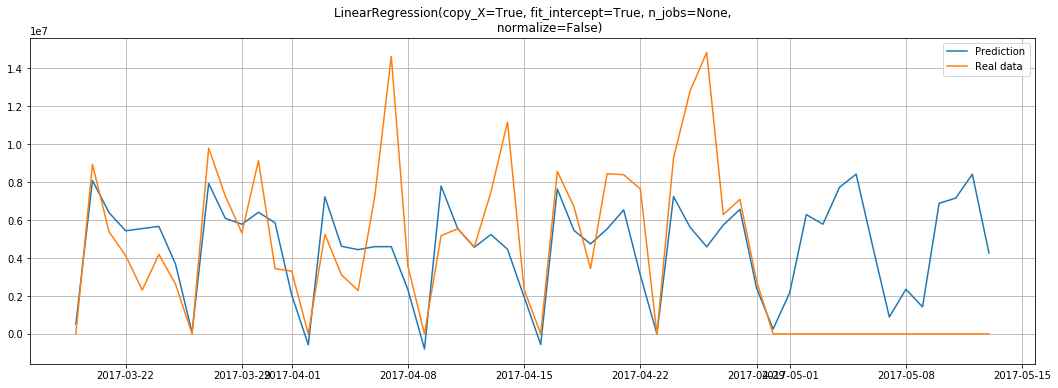

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Ошибка RMSE за период 73-75 составляет 245932.22214774083
Ошибка RMSE за период 75-77 составляет 382340.3932742516
Ошибка RMSE за период 77-79 составляет 516419.30500050506
Ошибка RMSE за период 79-81 составляет 394302.0655673626


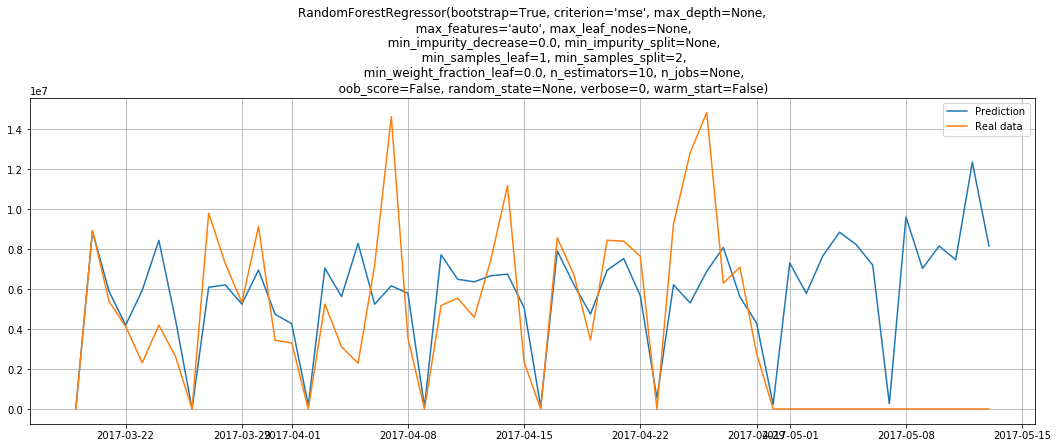

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Ошибка RMSE за период 73-75 составляет 232656.45184363905
Ошибка RMSE за период 75-77 составляет 370220.6398031532
Ошибка RMSE за период 77-79 составляет 527666.5276588305
Ошибка RMSE за период 79-81 составляет 284785.6674919848


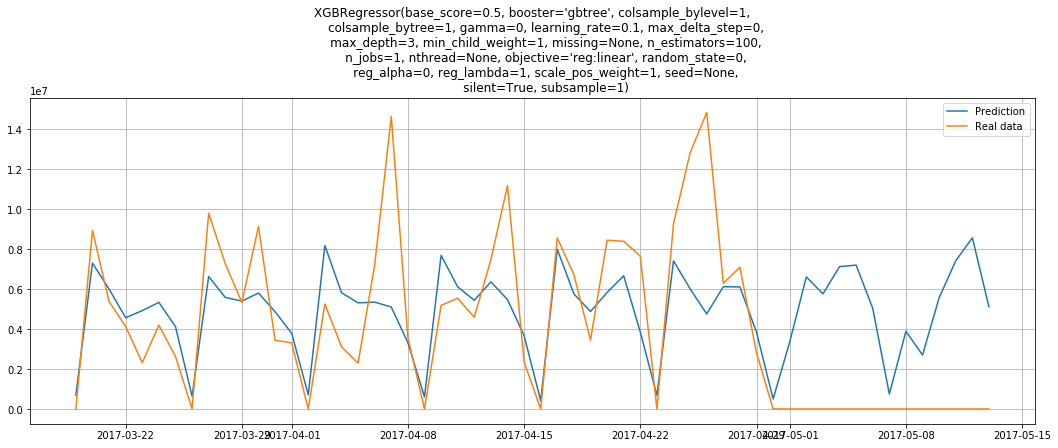

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Ошибка RMSE за период 73-75 составляет 230768.18892690638
Ошибка RMSE за период 75-77 составляет 373010.20695416967
Ошибка RMSE за период 77-79 составляет 526115.786607879
Ошибка RMSE за период 79-81 составляет 335781.2072846607


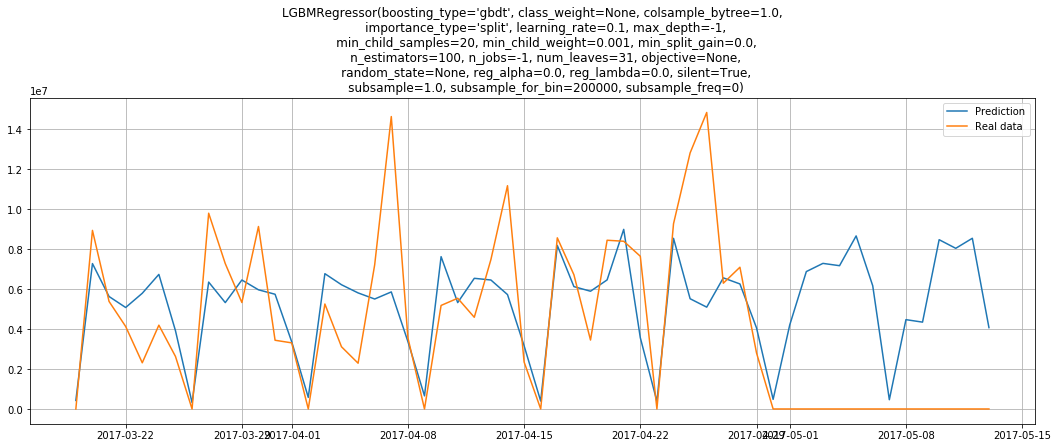

Ошибка RMSE за период 73-75 составляет 230261.17942865245
Ошибка RMSE за период 75-77 составляет 368320.68399336573
Ошибка RMSE за период 77-79 составляет 528384.9808325104
Ошибка RMSE за период 79-81 составляет 267957.2483315843


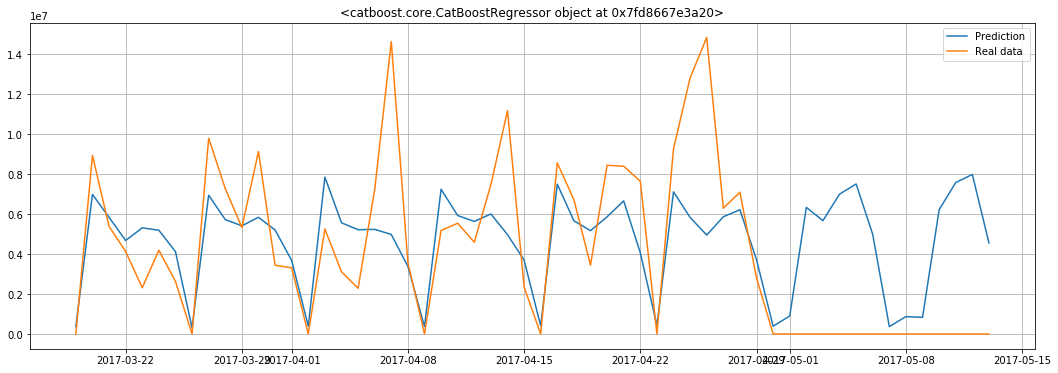

In [37]:

for idx, model in enumerate(models):
    print(model)
    
    
    pipe_lr = Pipeline([
        ('feature_union', FeatureUnion([
            ('num_pipe', num_pipe),
            ('cat_pipe', cat_pipe)
        ])),

        ('model', model)
    ])

    df1 = pd.DataFrame()    
        
    for i in range (73, 80, 2):
        X_train = full_df[full_df.week_num <i]
        y_train = full_df[full_df.week_num <i].amount

        X_valid = full_df[(full_df.week_num >=i)&(full_df.week_num <i+2)]
        y_valid = full_df[(full_df.week_num >=i)&(full_df.week_num <i+2)].amount


        y_pred = pipe_lr.fit(X_train, y_train).predict(X_valid)
        
        X_valid['y_pred'] = y_pred
        X_valid['y_true'] = y_valid
        
        
        
        fin_df = X_valid.groupby(['date', 'type'])[['y_true', 'y_pred']].sum().reset_index()
        
        df1 = df1.append(fin_df)
        
        print('Ошибка RMSE за период {}-{} составляет {}'.format(i,i+2, rmse (y_valid, y_pred)))
        
    
    plt.figure(figsize = (18,6))
    plt.plot(df1[df1.type == 1].date, df1[df1.type == 1].y_pred, label = 'Prediction')
    plt.plot(df1[df1.type == 1].date, df1[df1.type == 1].y_true, label = 'Real data')
    #plt.xlabel
    plt.grid()
    plt.legend()
    plt.title('{}'.format(model))
    plt.show()
        
    print('===========================================================================')
